In [0]:
#@title Default title text
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving return_2004_40.csv to return_2004_40.csv
User uploaded file "return_2004_40.csv" with length 1494219 bytes


In [1]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12
lookback = 3
chosen_stocks = ["AMZN"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [2]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [3]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [4]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(157, 12)


In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [7]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [126]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=256, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [127]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 6s 72ms/step - loss: 4.0180 - acc: 0.4321 - val_loss: 2.9492 - val_acc: 0.3889
Epoch 2/200
81/81 [==============================] - 0s 777us/step - loss: 2.6920 - acc: 0.4321 - val_loss: 2.7051 - val_acc: 0.3889
Epoch 3/200
81/81 [==============================] - 0s 776us/step - loss: 2.4705 - acc: 0.4321 - val_loss: 2.5303 - val_acc: 0.3889
Epoch 4/200
81/81 [==============================] - 0s 856us/step - loss: 2.3166 - acc: 0.4321 - val_loss: 2.3859 - val_acc: 0.3889
Epoch 5/200
81/81 [==============================] - 0s 866us/step - loss: 2.1959 - acc: 0.4321 - val_loss: 2.2664 - val_acc: 0.3889
Epoch 6/200
81/81 [==============================] - 0s 832us/step - loss: 2.0785 - acc: 0.4321 - val_loss: 2.1674 - val_acc: 0.3889
Epoch 7/200
81/81 [==============================] - 0s 820us/step - loss: 1.9926 - acc: 0.4321 - val_loss: 2.0803 - val_acc: 0.3889
Epoch 8/200
81/81 [=======

Epoch 62/200
81/81 [==============================] - 0s 810us/step - loss: 0.6996 - acc: 0.6049 - val_loss: 0.6653 - val_acc: 0.5833
Epoch 63/200
81/81 [==============================] - 0s 814us/step - loss: 0.7111 - acc: 0.5062 - val_loss: 0.6659 - val_acc: 0.5833
Epoch 64/200
81/81 [==============================] - 0s 800us/step - loss: 0.6826 - acc: 0.5556 - val_loss: 0.6665 - val_acc: 0.5833
Epoch 65/200
81/81 [==============================] - 0s 800us/step - loss: 0.7041 - acc: 0.5679 - val_loss: 0.6665 - val_acc: 0.5833
Epoch 66/200
81/81 [==============================] - 0s 784us/step - loss: 0.6969 - acc: 0.5309 - val_loss: 0.6671 - val_acc: 0.5833
Epoch 67/200
81/81 [==============================] - 0s 821us/step - loss: 0.7066 - acc: 0.4938 - val_loss: 0.6677 - val_acc: 0.5833
Epoch 68/200
81/81 [==============================] - 0s 806us/step - loss: 0.7123 - acc: 0.5309 - val_loss: 0.6684 - val_acc: 0.5833
Epoch 69/200
81/81 [==============================] - 0s 819us

Epoch 123/200
81/81 [==============================] - 0s 834us/step - loss: 0.7012 - acc: 0.4938 - val_loss: 0.6596 - val_acc: 0.6389
Epoch 124/200
81/81 [==============================] - 0s 796us/step - loss: 0.6951 - acc: 0.5432 - val_loss: 0.6596 - val_acc: 0.6389
Epoch 125/200
81/81 [==============================] - 0s 793us/step - loss: 0.6819 - acc: 0.5556 - val_loss: 0.6597 - val_acc: 0.6389
Epoch 126/200
81/81 [==============================] - 0s 778us/step - loss: 0.6976 - acc: 0.5556 - val_loss: 0.6597 - val_acc: 0.6389
Epoch 127/200
81/81 [==============================] - 0s 767us/step - loss: 0.6938 - acc: 0.5432 - val_loss: 0.6601 - val_acc: 0.6389
Epoch 128/200
81/81 [==============================] - 0s 801us/step - loss: 0.6941 - acc: 0.5556 - val_loss: 0.6606 - val_acc: 0.6111
Epoch 129/200
81/81 [==============================] - 0s 816us/step - loss: 0.6890 - acc: 0.5679 - val_loss: 0.6605 - val_acc: 0.6111
Epoch 130/200
81/81 [==============================] - 

Epoch 184/200
81/81 [==============================] - 0s 835us/step - loss: 0.6658 - acc: 0.6049 - val_loss: 0.6580 - val_acc: 0.6389
Epoch 185/200
81/81 [==============================] - 0s 855us/step - loss: 0.6793 - acc: 0.5309 - val_loss: 0.6578 - val_acc: 0.6389
Epoch 186/200
81/81 [==============================] - 0s 803us/step - loss: 0.6814 - acc: 0.5679 - val_loss: 0.6580 - val_acc: 0.6389
Epoch 187/200
81/81 [==============================] - 0s 782us/step - loss: 0.6772 - acc: 0.5802 - val_loss: 0.6575 - val_acc: 0.6389
Epoch 188/200
81/81 [==============================] - 0s 785us/step - loss: 0.6790 - acc: 0.5556 - val_loss: 0.6568 - val_acc: 0.6667
Epoch 189/200
81/81 [==============================] - 0s 777us/step - loss: 0.6864 - acc: 0.5432 - val_loss: 0.6561 - val_acc: 0.6667
Epoch 190/200
81/81 [==============================] - 0s 784us/step - loss: 0.6641 - acc: 0.5679 - val_loss: 0.6556 - val_acc: 0.6667
Epoch 191/200
81/81 [==============================] - 

26/26 [==============================] - 0s 291us/step
loss: 0.6913127899169922
acc: 0.5769230723381042


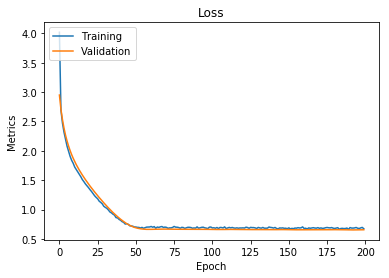

In [128]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [129]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [130]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.50372016]
 [0.51988614]
 [0.53276575]
 [0.5256243 ]
 [0.45529324]
 [0.49322414]
 [0.52749485]
 [0.4944974 ]
 [0.5038082 ]
 [0.5413115 ]
 [0.5234985 ]
 [0.51645035]
 [0.55019027]
 [0.50593674]
 [0.5175493 ]
 [0.5030674 ]
 [0.54126173]
 [0.5412949 ]
 [0.5489893 ]
 [0.5338336 ]
 [0.51475805]
 [0.5657638 ]
 [0.5660205 ]
 [0.54085934]
 [0.4806085 ]
 [0.6080689 ]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         9
        1.0       0.65      1.00      0.79        17

avg / total       0.43      0.65      0.52        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         9
        1.0       0.65      1.00      0.79        17

avg / total       0.43      0.65      0.52        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         9
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [142]:
import math

buy_list = []
sell_list = []

midpt = (max(map(lambda x: x[0], result)) + min(map(lambda x: x[0], result))) / 2

for i, r in enumerate(result):
  buy_or_sell = 1 if r.item() > midpt * 1 else (-1 if r.item() < midpt * 0.9 else 0)
  if r.item() > midpt * 1.1:
    buy_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  if r.item() < midpt * 0.9:
    sell_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  print(str(y_test[i].item()) + ": " + str(buy_or_sell))
  if (math.fabs(buy_or_sell - y_test[i].item()) == 2) or (buy_or_sell - y_test[i].item() == 1):
    print("Hey")
print(buy_list)
print(sell_list)

1.0: 0
0.0: 0
1.0: 1
1.0: 0
1.0: -1
Hey
1.0: 0
0.0: 0
0.0: 0
1.0: 0
1.0: 1
1.0: 0
0.0: 0
0.0: 1
Hey
1.0: 0
1.0: 0
1.0: 0
0.0: 1
Hey
1.0: 1
1.0: 1
1.0: 1
0.0: 0
0.0: 1
Hey
0.0: 1
Hey
1.0: 1
1.0: 0
1.0: 1
[{'month_id': 248, 'QAId': 'AMZN'}]
[{'month_id': 227, 'QAId': 'AMZN'}]


In [143]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)
dfSell.head(5)

,month_id,QAId
0,227,AMZN


In [145]:
# from google.colab import files

filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)